In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [14]:
protein = '1fme'
md_t2 = {'1fme': 18*1000}
order = [(53, 'fixed_k'), (60, 'fixed_k'), (52, 'fixed_k'), (47, 'worst'), (81, 'timescale_gap'), (60, 'timescale_gap'), (86, 'timescale_gap')]

In [15]:
summary_path = f'{protein}/summary.h5'

selection = pd.read_hdf(summary_path, key='model_selection')
timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
gaps = pd.read_hdf(summary_path, key='timescale_ratio')
gaps.reset_index(inplace=True)
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)

In [16]:
model_n = list(range(1, len(order)+1))
model_num_by_hp_ix = dict(zip(order, model_n))
selection['model'] = selection.apply(lambda x: model_num_by_hp_ix[(x['hp_ix'], x['method'])], axis=1)

In [17]:
method_labels = dict(fixed_k = 'Fixed $k$', timescale_gap =  'TS Gap', worst = 'Fixed $k$ (Worst)')
selection['method'] = selection['method'].apply(lambda x: method_labels.get(x, x))
new_index = selection.loc[:, ['hp_ix', 'lag', 'model']]

In [18]:
gaps = new_index.merge(gaps, on=['hp_ix', 'lag'], how='left')
timescales = new_index.merge(timescales, on=['hp_ix', 'lag'], how='left')
vamps = new_index.merge(vamps, on=['hp_ix', 'lag'], how='left')

In [21]:
vamps['median'] = 100*(1-vamps['median']/vamps['process'])
vamps['lb'] = 100*(1-vamps['lb']/vamps['process'])
vamps['ub'] = 100*(1-vamps['ub']/vamps['process'])
    

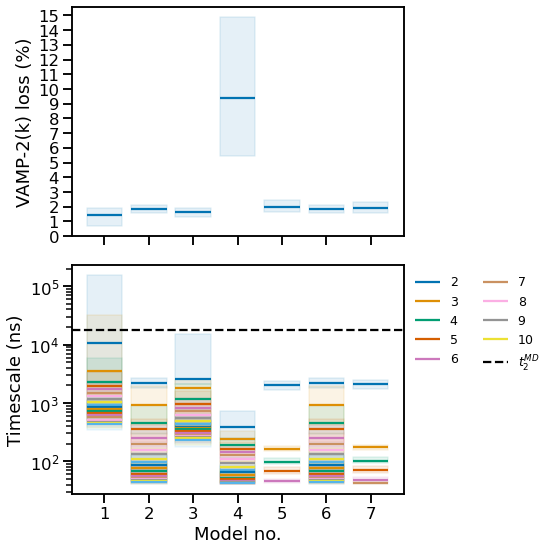

In [24]:
def plot_val_by_mod_proc(ax, value_df): 
    for (mod_n, proc), df in value_df.groupby(['model', 'process']):
        if mod_n == 1: 
            label = f"{proc}"
        else: 
            label = None
            
        ax.hlines(df['median'],  mod_n-width, mod_n+width, color=cols[proc-2], label=label)
        
        ax.fill_between([mod_n-width, mod_n+width], df['lb'], df['ub'], alpha=0.1, color=cols[proc-2])

        
with sns.plotting_context('talk', font_scale=1): 
    width =0.4
    offset = 0.5
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    
    cols = sns.color_palette('colorblind', timescales.process.max())
    
    vamp_ax = axes[0]
    
    plot_val_by_mod_proc(vamp_ax, vamps.query('process <= 2'))
    vamp_ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    vamp_ax.set_ylabel('VAMP-2(k) loss (%)')
    # axes[0].set_yscale('log')
    
    time_ax = axes[1]
    plot_val_by_mod_proc(time_ax, timescales)
    time_ax.set_yscale('log')
    time_ax.set_ylabel('Timescale (ns)')
    
    
    xlim = time_ax.get_xlim()
    time_ax.hlines(md_t2[protein], *xlim, color='k', label='$t_{2}^{MD}$', ls='dashed')
    time_ax.set_xlim(xlim)
    
    h, l = time_ax.get_legend_handles_labels()
    
    time_ax.legend(h[:9]+[h[-1]], l[:9]+[l[-1]], bbox_to_anchor=(1, 1), loc='upper left', edgecolor='w', 
                   ncol=2, fontsize='x-small')
#     plot_val_by_mod_proc(axes[2], gaps)
#     axes[2].set_yscale('log')
#     axes[2].set_ylabel('Timescale gap')
    
    axes[-1].set_xlabel('Model no.')
    
    for ax in axes.flatten():
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    
    plt.tight_layout()
    plt.savefig(f'{protein}/{protein}_timescale_comarison.png', bbox_inches='tight')

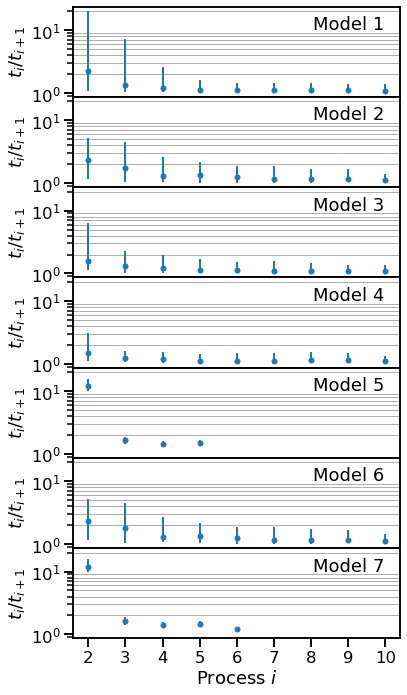

In [280]:
with sns.plotting_context('talk', font_scale=1):
    fig, axes = plt.subplots(gaps.model.max(), 1, figsize=(6, 10), sharey=True, sharex=True)
    delta = 0.1
    for mod_n, df in gaps.query('process <= 10').groupby('model'):
        
        yerr = (df['median']-df['lb'], df['ub'] - df['median'])
        ax = axes[mod_n-1]
        ax.errorbar(x=df['process'], y=df['median'], yerr=yerr,  marker='o', lw=0, markersize=5, 
                   elinewidth=2)
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        ax.grid(which='minor', alpha=1, lw=1)
        ax.set_yscale('log')
        ax.annotate(text=f"Model {mod_n}", xy=(0.95, 0.9), xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')
        
        ax.set_ylabel('$t_{i}/t_{i+1}$')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
                                   
    axes[-1].set_xlabel('Process $i$')
        
    plt.tight_layout(h_pad=-.5, w_pad=0)
    
    plt.savefig(f'{protein}/{protein}_gap_comparison.png', bbox_inches='tight')